In [1]:
import mindspore.dataset as ds
from mindvision.dataset import Mnist
import mindspore as ms

In [2]:
download_train = Mnist(path="data/MNIST/raw", split="train", batch_size=32, repeat_num=1, shuffle=True, resize=32, download=False)
download_eval = Mnist(path="data/MNIST/raw", split="test", batch_size=32, resize=32, download=False)
dataset_train = download_train.run()
dataset_eval = download_eval.run()

[WARNING] ME(24272:15388,MainProcess):2023-05-04-23:56:22.174.378 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(24272:15388,MainProcess):2023-05-04-23:56:22.176.380 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(24272:15388,MainProcess):2023-05-04-23:56:22.177.339 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(24272:15388,MainProcess):2023-05-04-23:56:22.178.336 [mindspore\dataset\core\validator_helpers.py:806] 'HWC

In [3]:
count = 0
for i in dataset_train:
    count += 1
    print(i[1])
    print(type(i[1]))
    print(i[0].shape)
    if count == 1:
        break

[5 8 3 5 0 7 6 1 2 9 4 6 6 5 0 4 5 7 0 8 8 0 9 5 1 9 8 5 3 8 9 0]
<class 'mindspore.common.tensor.Tensor'>
(32, 1, 32, 32)


In [4]:
from mindspore import nn

In [5]:
class VAE(nn.Cell):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.SequentialCell(
            nn.Dense(32*32, 256),
            nn.ReLU(),
            nn.Dense(256, 64),
            nn.ReLU(),
            nn.Dense(64, 20),
            nn.ReLU()
        )

        self.decoder = nn.SequentialCell(
            nn.Dense(10, 64),
            nn.ReLU(),
            nn.Dense(64, 256),
            nn.ReLU(),
            nn.Dense(256, 32*32),
            nn.Sigmoid()
        )
        self.split = ms.ops.Split(axis=1, output_num=2)
        self.randn = ms.ops.StandardNormal()
        self.sum = ms.ops.ReduceSum()
        self.pow = ms.ops.Pow()
        self.log = ms.ops.Log()

    def construct(self, x):
        batch_size = 32
        x = x.view(batch_size, 32*32)
        h_ = self.encoder(x)

        mu, sigma = self.split(h_)
        # print(mu, sigma)
        h = mu + sigma * self.randn(sigma.shape)

        x = self.decoder(h)
        x = x.view(batch_size, 1, 32, 32)

        """
        kld = 0.5 * torch.sum(
            torch.pow(mu, 2) +
            torch.pow(sigma, 2) -
            torch.log(1e-8 + torch.pow(sigma, 2)) - 1
        ) / (batch_size * 28 * 28)  # np.prod(x.shape) = batch_size * channel * h * w
        """

        kld = 0.5 * self.sum(
            self.pow(mu, 2) +
            self.pow(sigma, 2) -
            self.log(1e-8 + self.pow(sigma, 2)) - 1
        ) / (batch_size * 32 * 32)

        return x, kld


In [6]:
class WithLossCell(nn.Cell):
    def __init__(self, net, loss_function):
        super(WithLossCell, self).__init__()
        self.net = net
        self.loss_function = loss_function

    def construct(self, x):
        x_hat, kld = net(x)
        loss = loss_function(x_hat, x)
        return loss + kld

In [7]:
net = VAE()
print(net)
loss_function = nn.MSELoss()
opt = nn.Adam(net.trainable_params(), learning_rate=0.001)

VAE<
  (encoder): SequentialCell<
    (0): Dense<input_channels=1024, output_channels=256, has_bias=True>
    (1): ReLU<>
    (2): Dense<input_channels=256, output_channels=64, has_bias=True>
    (3): ReLU<>
    (4): Dense<input_channels=64, output_channels=20, has_bias=True>
    (5): ReLU<>
    >
  (decoder): SequentialCell<
    (0): Dense<input_channels=10, output_channels=64, has_bias=True>
    (1): ReLU<>
    (2): Dense<input_channels=64, output_channels=256, has_bias=True>
    (3): ReLU<>
    (4): Dense<input_channels=256, output_channels=1024, has_bias=True>
    (5): Sigmoid<>
    >
  >


In [8]:
import numpy as np

In [9]:
with_loss = WithLossCell(net, loss_function)
train_step = nn.TrainOneStepCell(with_loss, opt).set_train()

In [10]:
import tqdm

In [11]:
for epoch in range(1):
    for x_train, _ in tqdm.tqdm(dataset_train):
        loss = train_step(x_train)
    print('epoch: {0}, loss is {1}'.format(epoch, loss))

1875it [00:48, 38.70it/s]


epoch: 0, loss is 0.5925172


1875it [01:35, 19.56it/s]

epoch: 1, loss is 0.61713034


(-0.5, 31.5, 31.5, -0.5)

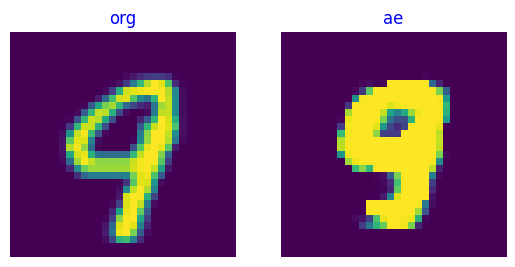

In [19]:
import matplotlib.pyplot as plt
count = 0
for x_eval, _ in dataset_eval:
    if count == 1:
        break
x_hat, _ = net(x_eval)

x_eval1 = x_eval[0].asnumpy()
x_hat1 = x_hat[0].asnumpy()

plt.subplot(1, 2, 1)
plt.title("org", color='blue')
plt.imshow(np.squeeze(x_eval1))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("ae", color='blue')
plt.imshow(np.squeeze(x_hat1))
plt.axis("off")